# In the name of God
### HW6
### Deep Q-Learning



**Name:** Mohammad Navid Fazly

**Std. No.:** 99100477


### Deep Q-Learning (DQN)

Deep Q-Learning is a popular algorithm in reinforcement learning that combines the ideas of Q-learning, a traditional reinforcement learning method, with deep neural networks. The goal is to train an agent to make decisions by estimating the optimal action-value function Q, which represents the expected cumulative future rewards for taking a particular action in a given state.

Key components of DQN:

- **Experience Replay:** To break the temporal correlation in sequential data and improve sample efficiency, we use an experience replay buffer to store and sample past experiences.
- **Target Networks:** The use of two separate networks, the main network and a target network, helps stabilize training by decoupling the update targets from the online network's constantly changing values.

### The Lunar Lander Problem

The task is to control a lunar lander and guide it to land safely on the moon's surface. The agent needs to learn a policy that takes into account the lunar lander's state (position, velocity, angle, angular velocity, etc.) and chooses appropriate actions (thrust left, thrust right, thrust up, or do nothing) to achieve a safe landing.

### Overview

- **Environment:** LunarLander-v2 from OpenAI Gym.
- **Objective:** Train an agent to learn a policy for landing the lunar lander safely.
- **Techniques:** Deep Q-Learning, Experience Replay, Target Networks.

### Instructions

1. Follow the instructions and comments in the code cells to implement and understand each component.
2. Replace the `#####TO DO#####` placeholders with your code.
3. Experiment with hyperparameters and observe how they affect the training process.
4. Run the notebook to train the agent and play the game with the trained model.
5. Answer any provided questions or tasks to reinforce your understanding.

### Prerequisites

Make sure you have the following libraries installed:


In [ ]:
!pip install --upgrade setuptools wheel

In [ ]:
!pip install swig
!pip install gym==0.24.0

# Imports

In [ ]:
pip install gym==0.24.0


In [ ]:
import gym

print("Gym version:", gym.__version__)


Gym version: 0.24.0


In [ ]:
import numpy as np
import gym
import time
import torch
import torch.nn as nn
import torch.optim as optim
import os
import collections
import matplotlib.pyplot as plt
import collections
!pip install gym[box2d]

env = gym.make('LunarLander-v2')

In [ ]:

class DQN(nn.Module):
    def __init__(self, in_features, n_actions):
        """
        Initialize the Deep Q-Network (DQN).

        Parameters:
        - in_features (int): Number of input features (dimension of the state).
        - n_actions (int): Number of possible actions in the environment.
        """
        super(DQN, self).__init__()

        # TODO: Implement the neural network architecture
        # Use Linear layers with ReLU
        # Number of hidden units in each layer:
        # - Layer 1: 256 units
        # - Layer 2: 128 units
        # - Layer 3: 64 units
        self.fc1 = nn.Linear(in_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_actions)


    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
        - x (torch.Tensor): Input tensor representing the state.

        Returns:
        - torch.Tensor: Output tensor representing Q-values for each action.
        """
        # TODO: Implement the forward pass
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x



In [ ]:
class ExperienceBuffer():
    def __init__(self, capacity):
        """
        Initialize the Experience Replay Buffer.

        Parameters:
        - capacity (int): Maximum capacity of the buffer.
        """
        self.exp_buffer = collections.deque(maxlen=capacity)

    def append(self, exp):
        """
        Append a new experience to the buffer.

        Parameters:
        - exp (tuple): Tuple representing a single experience (state, action, reward, done, next_state).
        """
        self.exp_buffer.append(exp)

    def __len__(self):
        """
        Get the current size of the buffer.

        Returns:
        - int: Number of experiences currently stored in the buffer.
        """
        return len(self.exp_buffer)

    def clear(self):
        """Clear all experiences from the buffer."""
        self.exp_buffer.clear()

    def sample(self, batch_size):
        """
        Sample a batch of experiences from the buffer.

        Parameters:
        - batch_size (int): Size of the batch to be sampled.

        Returns:
        - tuple: Batch of experiences (states, actions, rewards, dones, next_states).
        """
        # Randomly sample `batch_size` experiences from the buffer
        batch = random.sample(self.exp_buffer, batch_size)

        # Separate the components of each experience into separate lists
        states, actions, rewards, dones, next_states = zip(*batch)

        # Convert lists to NumPy arrays with appropriate data types
        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int64)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=bool)
        next_states = np.array(next_states, dtype=np.float32)

        return states, actions, rewards, dones, next_states


In [ ]:
class Agent():
    def __init__(self, env, buffer):
        """
        Initialize the agent.

        Parameters:
        - env: The environment the agent interacts with.
        - buffer: Experience replay buffer to store agent experiences.
        """
        self.env = env
        self.buffer = buffer
        self._reset()

    def _reset(self):
        """
        Reset the agent's state and total rewards to the initial state.
        """
        self.state = env.reset()
        self.total_rewards = 0.0

    def step(self, net, eps, device="cpu"):
        """
        TODO: Implement the exploration-exploitation strategy (epsilon-greedy) here.

        Take a step in the environment using the provided neural network.

        Parameters:
        - net: The neural network representing the agent's policy.
        - eps (float): Epsilon value for epsilon-greedy exploration.
        - device (str): Device for neural network computations.

        Returns:
        - done_reward: Total rewards obtained in the episode if it is finished, otherwise None.
        """
        done_reward = None

        # Convert state to tensor and move to device
        state_tensor = torch.tensor(self.state, dtype=torch.float32).unsqueeze(0).to(device)

        # Epsilon-greedy strategy
        if torch.rand(1).item() < eps:
            # Explore: Select a random action
            action = self.env.action_space.sample()
        else:
            # Exploit: Select the action with maximum Q-value
            with torch.no_grad():
                q_values = net(state_tensor)
                action = q_values.argmax(dim=1).item()

        # Take the selected action
        next_state, reward, done, _ = self.env.step(action)

        # Update total rewards
        self.total_rewards += reward

        # Append the experience to the buffer
        self.buffer.append((self.state, action, reward, done, next_state))

        # If episode is finished, reset the environment
        if done:
            done_reward = self.total_rewards
            self._reset()
        else:
            self.state = next_state

        return done_reward


In [ ]:
# Hyperparameters
GAMMA = 0.99  # Discount factor for future rewards
EPSILON_START = 1.0  # Initial exploration probability (epsilon-greedy)
EPSILON_FINAL = 0.01  # Final exploration probability (epsilon-greedy)
EPSILON_DECAY_OBS = 10**5  # Number of observations for epsilon decay
BATCH_SIZE = 32  # Size of the experience replay batch
MEAN_GOAL_REWARD = 130  # Mean reward goal for solving the environment
REPLAY_BUFFER_SIZE = 10000  # Maximum capacity of the experience replay buffer
REPLAY_MIN_SIZE = 10000  # Minimum size of the experience replay buffer before training begins
LEARNING_RATE = 4e-4  # Learning rate for the neural network optimizer
SYNC_TARGET_OBS = 1000  # Number of observations before synchronizing target and online networks
PLOT_INTERVAL = 10000

In [ ]:
import torch

def cal_loss(batch, net, tgt_net, device='cpu'):
    """
    Implement the loss calculation for Deep Q-Learning.

    Calculate the loss for Deep Q-Learning.

    Parameters:
    - batch (tuple): Batch of experiences (states, actions, rewards, dones, next_states).
    - net: The neural network representing the online Q-network.
    - tgt_net: The neural network representing the target Q-network.
    - device (str): Device for neural network computations (default is "cpu").

    Returns:
    - torch.Tensor: Loss value calculated using Mean Squared Error (MSE) loss.
    """

    states, actions, rewards, dones, next_states = batch
    states_v = torch.tensor(states, dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards, dtype=torch.float32).to(device)
    dones_v = torch.BoolTensor(dones).to(device)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)

    # Calculate Q-values for the current states and selected actions
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    # Calculate the maximum Q-value for the next states using the target network
    next_state_values = tgt_net(next_states_v).max(1)[0]

    # Zero out Q-values for terminal states
    next_state_values[dones_v] = 0.0

    # Detach Q-values for the next states to avoid gradient flow
    next_state_values = next_state_values.detach()

    # Calculate the expected return for the current states
    expected_state_action_values = rewards_v + next_state_values * GAMMA

    # Calculate the Mean Squared Error (MSE) loss
    loss = torch.nn.functional.mse_loss(state_action_values, expected_state_action_values)

    return loss


# Learning Curves
 Plot learning curves showing key metrics (e.g., total rewards, loss) over the course of training. Analyze the trends and identify key points in the learning process.

In [ ]:
import random

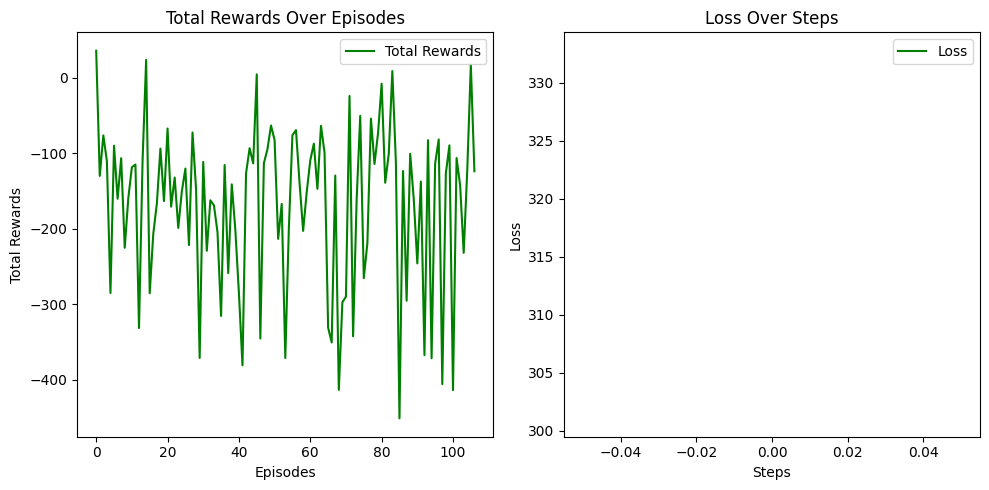


Mean Reward:  -171.61706813430268


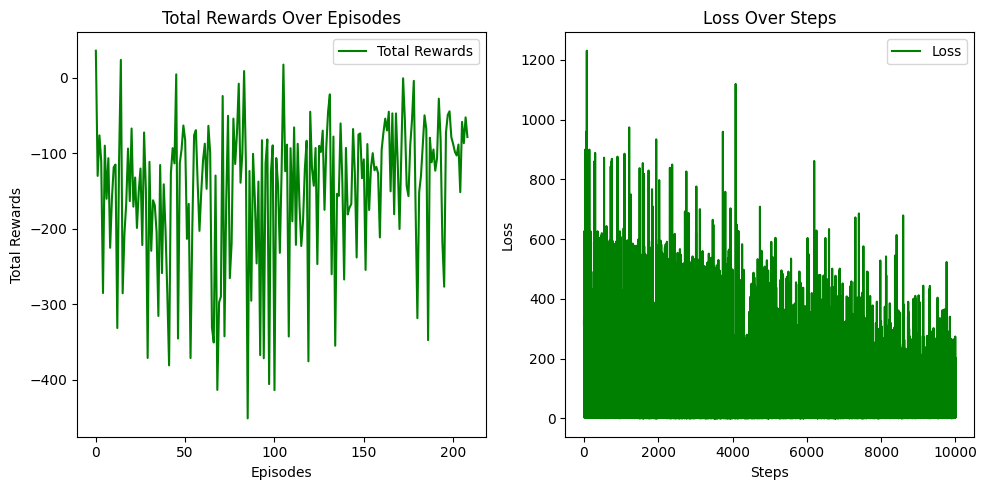


Mean Reward:  -124.71112322167703


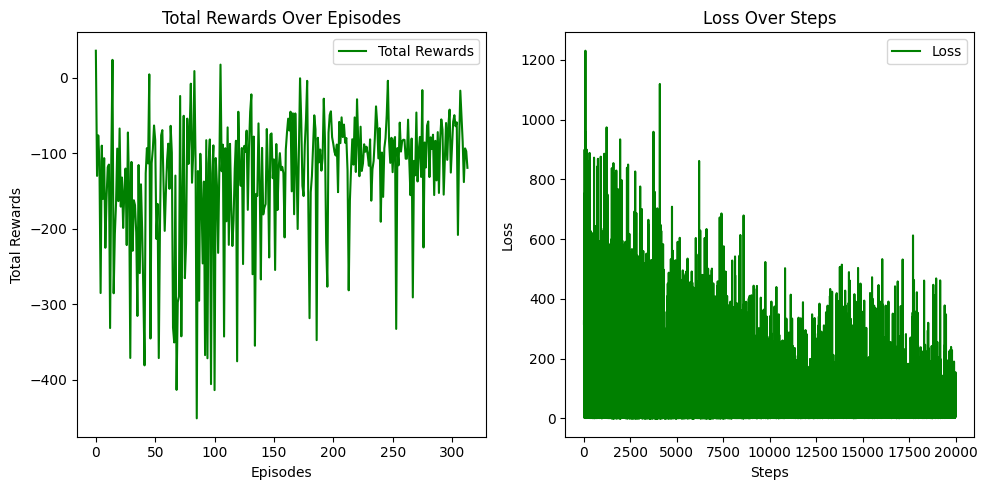


Mean Reward:  -99.86932958649369


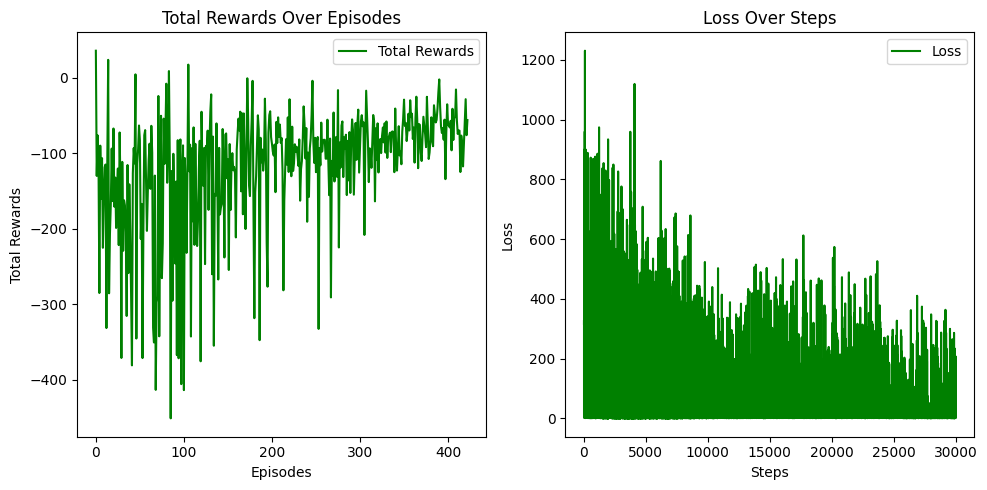


Mean Reward:  -70.89730517815376


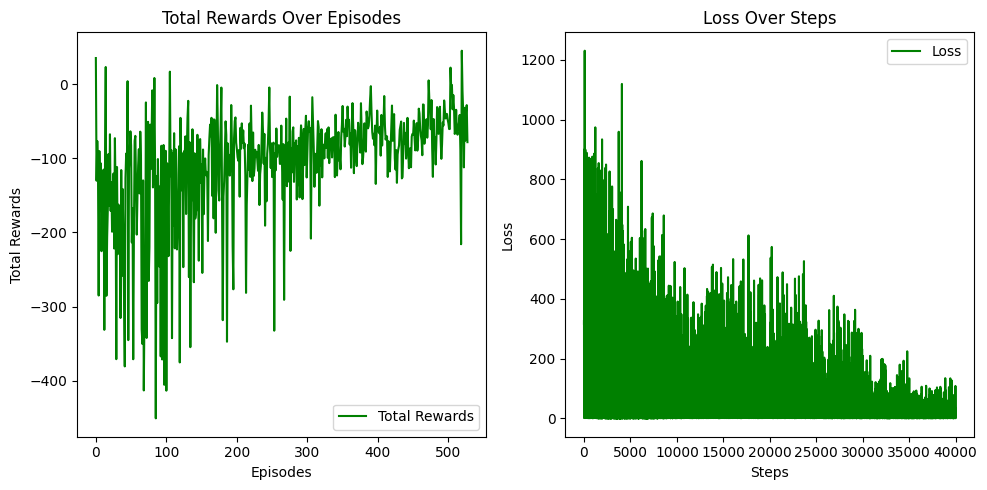


Mean Reward:  -60.693722249216556


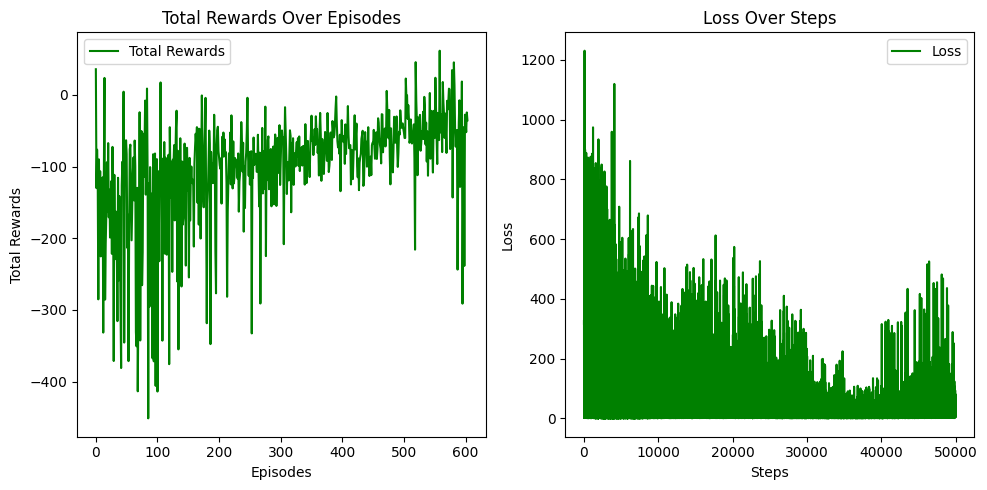


Mean Reward:  -50.819971366319145


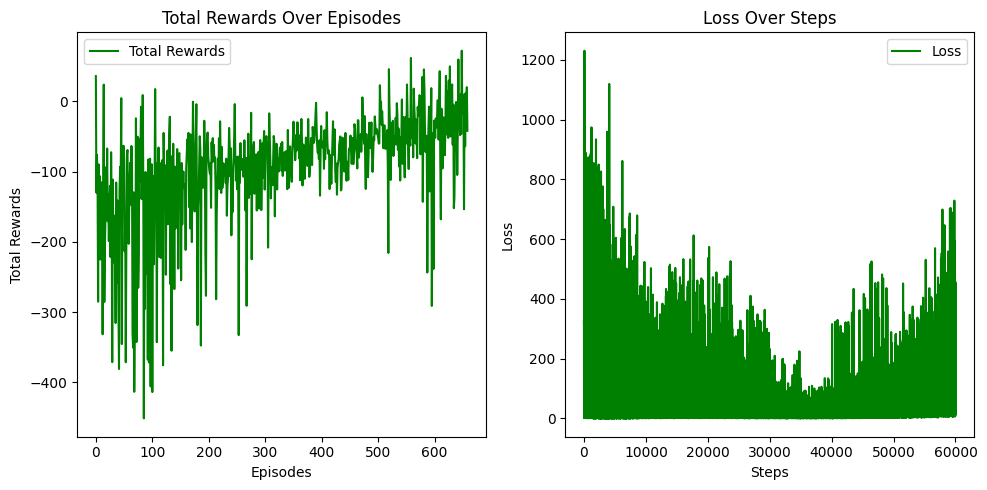


Mean Reward:  -39.76722279378785


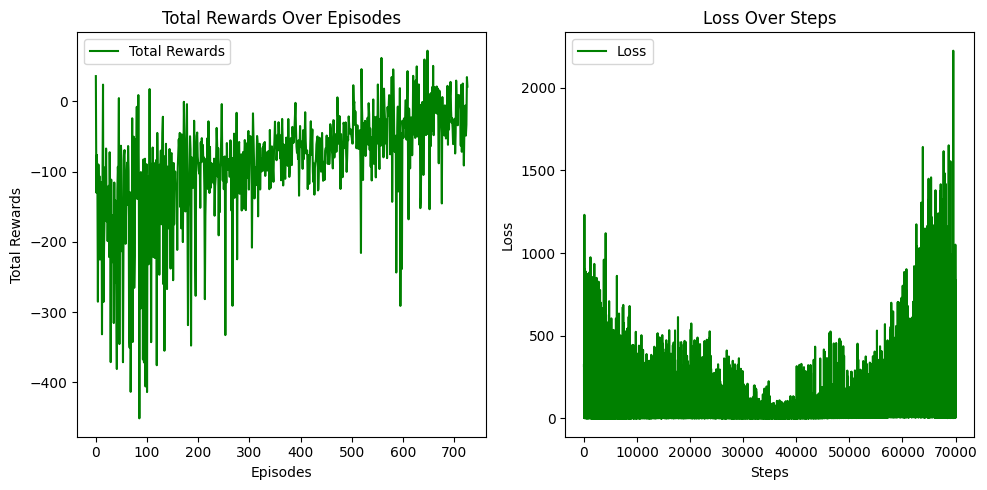


Mean Reward:  -21.843316620220293


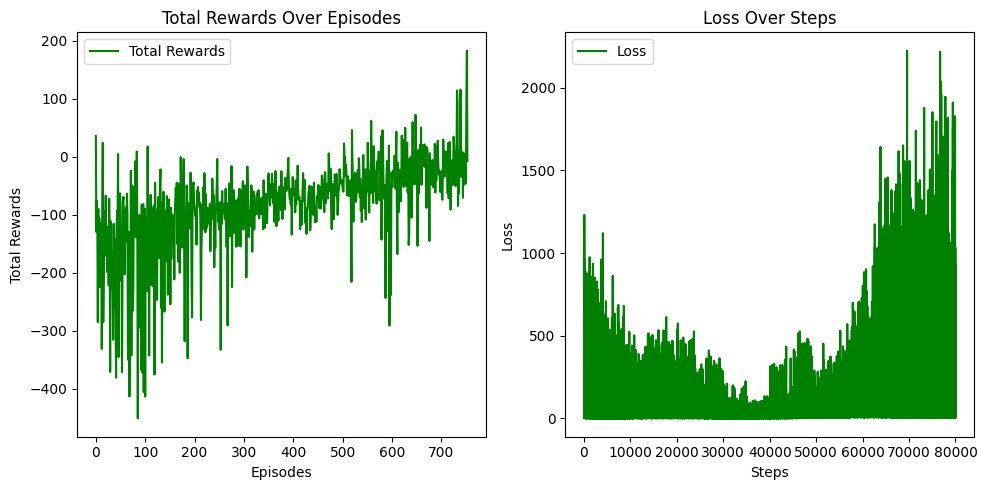


Mean Reward:  -13.02073711008568


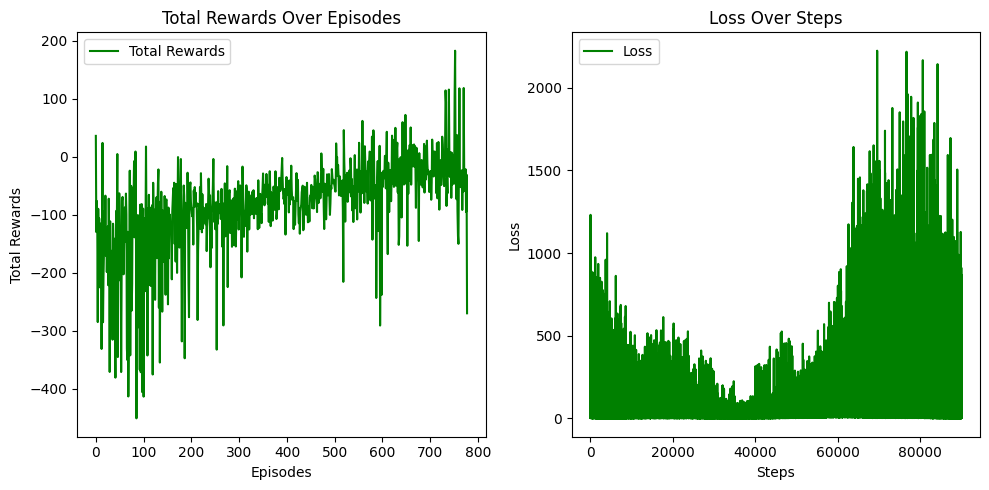


Mean Reward:  -21.272995635531192


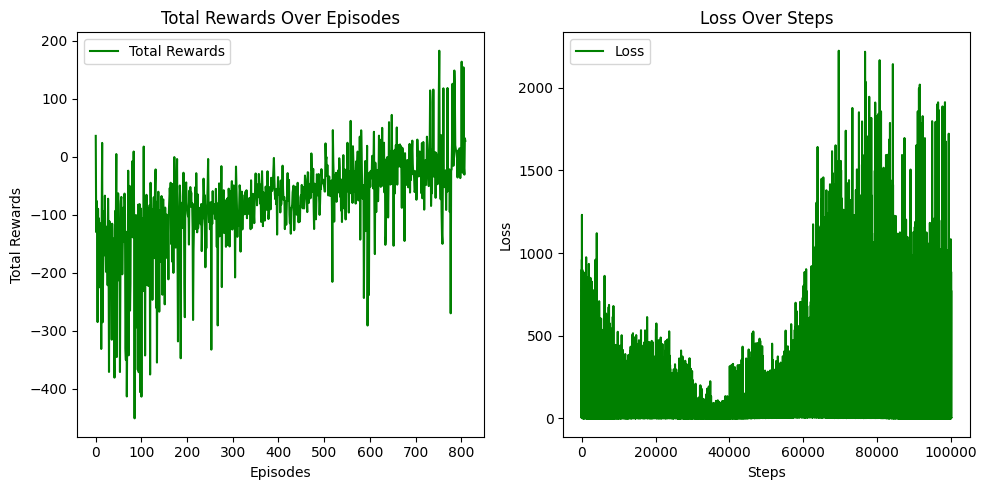


Mean Reward:  -7.571049384377663


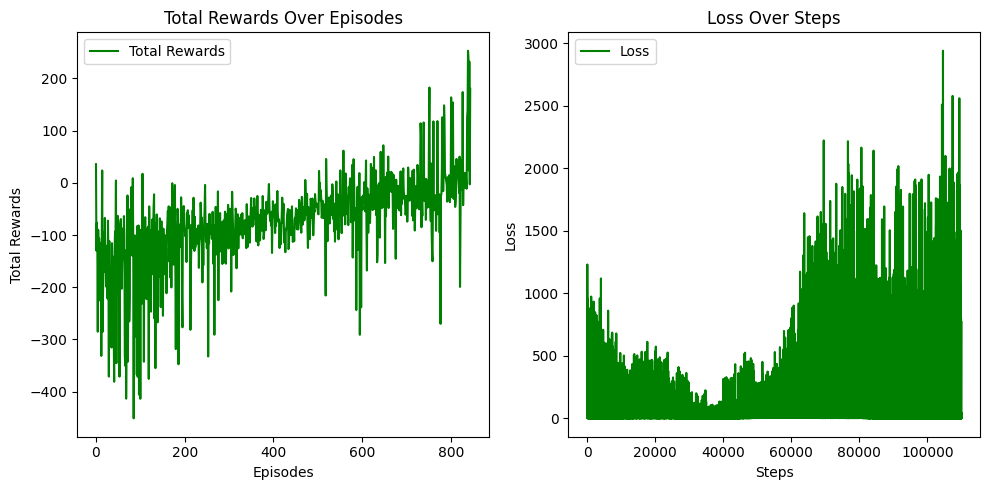


Mean Reward:  8.29422291596801
GAME : 129686, TIME ECLAPSED : 1.1863579750061035, EPSILON : 0.01, MEAN_REWARD : 51.266416017703115
Reward 48.60607323235009 -> 51.266416017703115 Model Saved


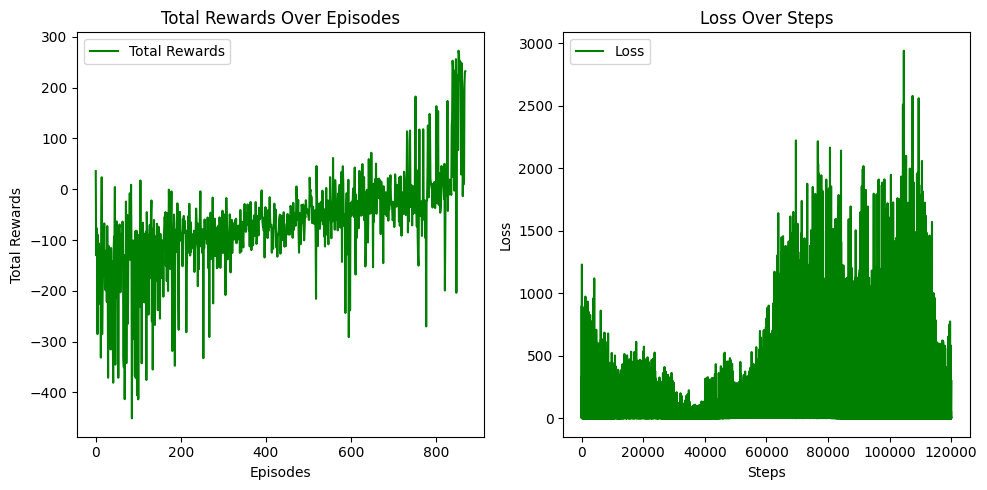


Mean Reward:  54.194475252705324
GAME : 131487, TIME ECLAPSED : 0.9644520282745361, EPSILON : 0.01, MEAN_REWARD : 61.64096096263577
Reward 58.73469894613217 -> 61.64096096263577 Model Saved
GAME : 134244, TIME ECLAPSED : 0.8156895637512207, EPSILON : 0.01, MEAN_REWARD : 72.69445081114024
Reward 70.18284541136082 -> 72.69445081114024 Model Saved
GAME : 137325, TIME ECLAPSED : 3.700684070587158, EPSILON : 0.01, MEAN_REWARD : 83.02703739096192
Reward 80.49102194802269 -> 83.02703739096192 Model Saved
GAME : 139372, TIME ECLAPSED : 2.01265287399292, EPSILON : 0.01, MEAN_REWARD : 93.44173377602132
Reward 91.42382470431116 -> 93.44173377602132 Model Saved


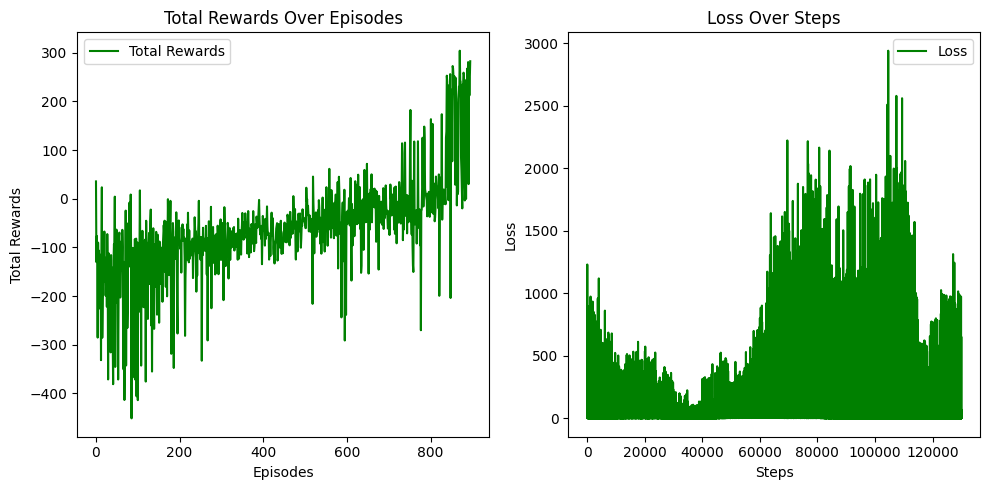


Mean Reward:  99.09609011906828
GAME : 141714, TIME ECLAPSED : 1.6904892921447754, EPSILON : 0.01, MEAN_REWARD : 105.0536551279458
Reward 101.9836608780742 -> 105.0536551279458 Model Saved
GAME : 143224, TIME ECLAPSED : 0.4908928871154785, EPSILON : 0.01, MEAN_REWARD : 113.96813073667053
Reward 113.58329031610565 -> 113.96813073667053 Model Saved
GAME : 149515, TIME ECLAPSED : 2.1689796447753906, EPSILON : 0.01, MEAN_REWARD : 125.90521050365687
Reward 123.61599803488909 -> 125.90521050365687 Model Saved


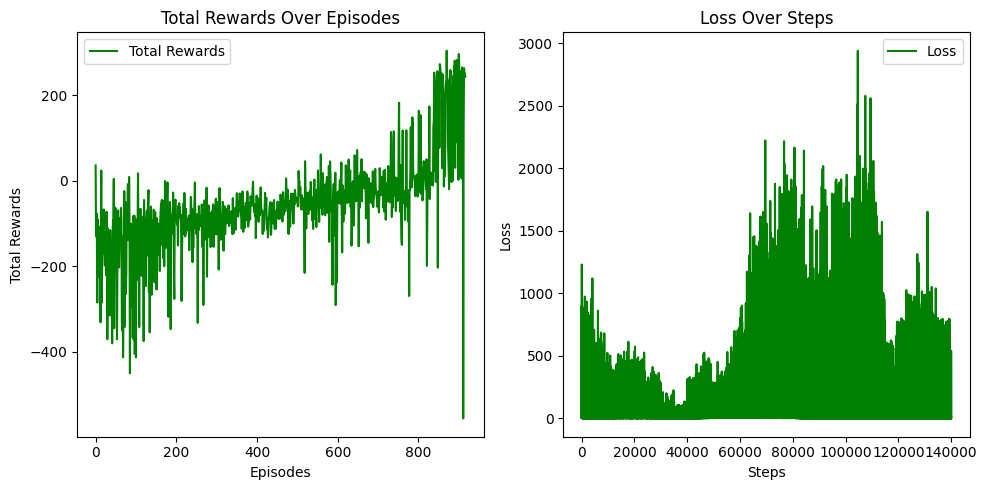


Mean Reward:  128.20299759500122
SOLVED in 151610 obs


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)

buffer = ExperienceBuffer(REPLAY_BUFFER_SIZE)

agent = Agent(env, buffer)

epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Lists to track total rewards and losses over training
total_rewards = []
losses = []

# Initialize time variables for tracking training time
ts = time.time()
best_mean_reward = None
obs_id = 0

while True:
    obs_id += 1

    # Update exploration rate based on epsilon decay schedule
    epsilon = max(EPSILON_FINAL, EPSILON_START - obs_id/EPSILON_DECAY_OBS)

    # Agent takes a step in the environment, receives a reward
    reward = agent.step(net, epsilon, device=device)

    if reward is not None:
        # Store total rewards and update game time
        total_rewards.append(reward)
        game_time = time.time() - ts
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])


        if best_mean_reward is None or best_mean_reward < mean_reward:
            torch.save(net.state_dict(), './lunar_lander-best.dat')

            if best_mean_reward is None:
                last = mean_reward
                best_mean_reward = mean_reward

            if best_mean_reward is not None and best_mean_reward - last > 10:
                last = best_mean_reward
                print("GAME : {}, TIME ECLAPSED : {}, EPSILON : {}, MEAN_REWARD : {}"
                      .format(obs_id, game_time, epsilon, mean_reward))
                print("Reward {} -> {} Model Saved".format(best_mean_reward, mean_reward))

            best_mean_reward = mean_reward

        if mean_reward > MEAN_GOAL_REWARD:
            print("SOLVED in {} obs".format(obs_id))
            break

    # Continue training if the replay buffer size is below the minimum required
    if len(buffer) < REPLAY_MIN_SIZE:
        continue

    # Synchronize target network with the Q-network at regular intervals
    if obs_id % SYNC_TARGET_OBS == 0:
        tgt_net.load_state_dict(net.state_dict())

    # TODO: Implement the training process (calculating loss, backpropagation, and optimizer step)
    # Sample a batch of experiences from the replay buffer
    batch = buffer.sample(BATCH_SIZE)

    # Calculate the loss
    loss = cal_loss(batch, net, tgt_net, device=device)

    # Perform backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Clip gradients to avoid exploding gradients
    for param in net.parameters():
        param.grad.data.clamp_(-1, 1)

    # Update the parameters of the Q-network
    optimizer.step()

    # Append the loss value to the list of losses
    losses.append(loss.item())

    # Plot learning curves every few episodes or steps
    if obs_id % PLOT_INTERVAL == 0:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(total_rewards, label='Total Rewards', color='green')
        plt.xlabel('Episodes')
        plt.ylabel('Total Rewards')
        plt.title('Total Rewards Over Episodes')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(losses, label='Loss', color='green')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Loss Over Steps')
        plt.legend()

        plt.tight_layout()
        plt.show()
        print("\nMean Reward: ", mean_reward)




# Visual Comparison:

write a function to render and display the environment before and after training. What visual differences do you observe in the agent's behavior? Discuss it. Also, Upload the Videos with your notebook. You can use the following library for rendering and saving videos.

In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"


In [ ]:
import imageio

# Helper function for rendering and saving a video
def render_and_save_video(env, net, episodes=10, save_path="./render_video.mp4", device="cpu"):
    # Initialize the video writer
    writer = imageio.get_writer(save_path, format='ffmpeg', fps=30)

    # Iterate through episodes
    for episode in range(episodes):
        # Reset the environment for each episode
        state = env.reset()
        done = False

        # Run the episode until termination
        while not done:
            # Render the environment
            frame = env.render(mode='rgb_array')

            # Append the frame to the video
            writer.append_data(frame)

            # Choose an action using the neural network
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values = net(state_tensor)
                action = q_values.argmax().item()

            # Take the action in the environment
            next_state, _, done, _ = env.step(action)
            state = next_state

    # Close the video writer
    writer.close()

# Render and save a video before training
print("### BEFORE TRAINING ###")
render_and_save_video(env, net, device=device,save_path = './before.mp4')

# Render and save a video after training
print("### AFTER TRAINING ###")
render_and_save_video(env, net, device=device,save_path = './after.mp4')


### BEFORE TRAINING ###


### AFTER TRAINING ###


In [ ]:
pip install imageio[ffmpeg]

# Question:

Exploration (Epsilon-Greedy):

Discuss the significance of the exploration strategy, specifically the Epsilon-Greedy approach, in balancing exploration and exploitation during training.


One of the simplest and most widely used exploration strategies is the Epsilon-Greedy approach. In this approach, the agent chooses a random action with a small probability epsilon, and chooses the best action according to its current estimate of the action-value function with a probability of one minus epsilon. This way, the agent can explore the environment with some probability, and exploit its knowledge with the remaining probability. The value of epsilon can be fixed or decay over time, depending on the problem and the agent’s preferences.

The Epsilon-Greedy approach is significant because it is easy to implement, computationally efficient, and theoretically sound. It can be applied to any reinforcement learning algorithm that uses an action-value function, such as Q-learning or SARSA. It can also be proven that the Epsilon-Greedy approach converges to the optimal policy with probability one, as long as epsilon is sufficiently small and the agent visits each state-action pair infinitely often. Moreover, the Epsilon-Greedy approach can be adapted to different scenarios by tuning the value of epsilon or using other variants, such as Epsilon-Decreasing or Epsilon-First.

However, the Epsilon-Greedy approach also has some limitations and challenges. For example, it can be difficult to choose the optimal value of epsilon, as it depends on the characteristics of the environment, the agent, and the learning task. A too large epsilon can lead to excessive exploration and slow convergence, while a too small epsilon can result in insufficient exploration and suboptimal performance. Furthermore, the Epsilon-Greedy approach can be inefficient in large or complex environments, as it does not take into account the uncertainty or the potential of the actions. It can also be sensitive to noise or outliers in the rewards, as it always chooses the action with the highest estimated value.